# IMDB-5000 Dataset Analysis - *Given information about a movie, predict whether it is terrible, bad, good or great.*

Last updated: November 2020

## How is this useful?

Developing an accurate model that can predict whether or not a movie would successful in the eyes of audiences would be quite useful for first time film makers who have no idea what kind of resources to invest in their movie. It would also be useful for production companies who want to maximise output of good movies. These kinds of people could take the model and input the resources that they have on hand and the model will tell them what kind of audience they can expect to some degree of accuracy. 

This could also be useful for predicting how good a movie that has not been released yet will be. One could use the model to predict how good an upcoming movie will be and do something with this information, such as bet on it.

## About the Dataset

The IMDB-5000 dataset is of size (5043,28), meaning we have 5043 observations (datapoints) and 28 features (variables). The variables are things like:

* Director name
* Duration
* Names of top 3 actors in the movie
* Language
* Budget
* Gross
* Number of Facebook likes for director and top 3 actors

The data is open source and can be viewed/downloaded from https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset

## About this Notebook

This analysis is split into 4 parts:

### Part 1: Dataset Exploration
    1. Visualising the data
    2. Dealing with Missing Values
    3. Removing Highly Co-Correlated Features
### Part 2: Dataset Preprocessing
    1. Categorising the Dependent Variable
    2. Splitting the data into Independent & Dependent Variables
    3. Feature Scaling
    4. Train-Test Split
### Part 3: Model Training & Evaluation
    1. Naïve Bayes
    2. K-Nearest Neighbours
    3. Support Vector Machine
    4. Random Forest Classifier
    5. XGBoost Classifier
    6. Ariticial Neural Network Classifier
    7. Model Comparison
### Part 4: Summary and Conclusions
    1. Key Takeaways
    2. Limitations & Future Work

## Part 1: Dataset Exploration

#### In this section we begin to sort through the data and examine the features. We will visualise the data, deal with missing values, remove highly correlated features and any other features that are not relevant or useful for the analysis.

In [322]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

We can start to get a feel for the dataset by using dataset.describe(). This will tell some descriptive summary statistics for each feature in our dataset. We can use this to find out things like the mean, std, max and min for numerical features and the number of unique values for categorical features.

In [323]:
# read in the dataset, print shape and column titles
dataset = pd.read_csv('movie_metadata.csv')
print(dataset.describe(include='all'))
print("Dataset shape: ", dataset.shape)
print("Dataset columns: ", dataset.columns)

        color     director_name  num_critic_for_reviews     duration  \
count    5024              4939             4993.000000  5028.000000   
unique      2              2398                     NaN          NaN   
top     Color  Steven Spielberg                     NaN          NaN   
freq     4815                26                     NaN          NaN   
mean      NaN               NaN              140.194272   107.201074   
std       NaN               NaN              121.601675    25.197441   
min       NaN               NaN                1.000000     7.000000   
25%       NaN               NaN               50.000000    93.000000   
50%       NaN               NaN              110.000000   103.000000   
75%       NaN               NaN              195.000000   118.000000   
max       NaN               NaN              813.000000   511.000000   

        director_facebook_likes  actor_3_facebook_likes    actor_2_name  \
count               4939.000000             5020.000000     

We can now remove some features that won't be useful to us or are too sparsely encoded to give any value.

In [324]:
dataset = dataset.drop(columns=['color','director_name','plot_keywords',
                                'movie_title','actor_1_name','actor_2_name','actor_3_name'])

print(dataset.shape)

(5043, 21)


Next, we can visualise the dependent variable (imdb_score). We can see that this distribution is normal but has negative skew.

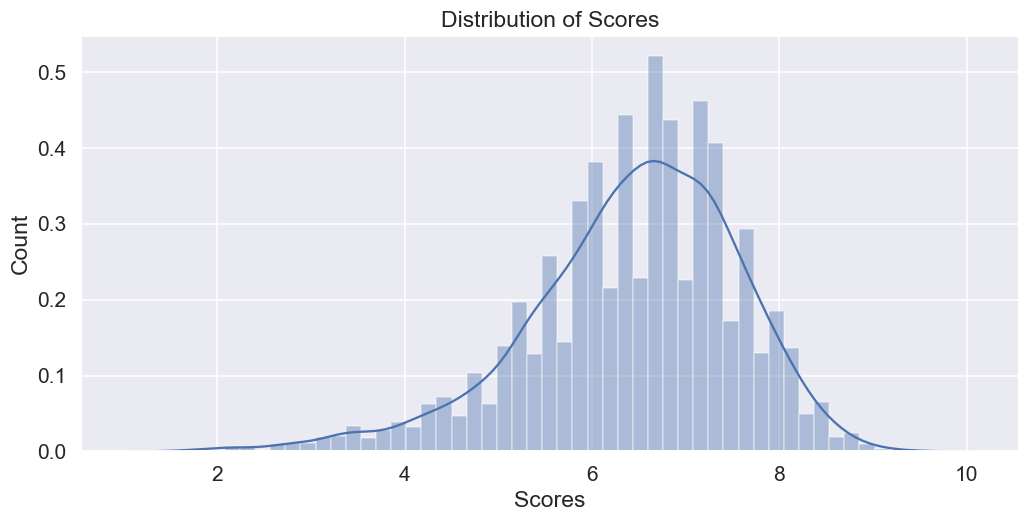

Skew of sale price:  -0.7414713363265145


In [325]:
# move the dependent variable to the end of the dataframe
scores = list(dataset.iloc[:, -3].values)
dataset = dataset.drop(columns='imdb_score')
dataset['scores'] = scores

plt.figure(dpi=110,figsize=(11,5))
sns.distplot(dataset['scores'])
plt.xlabel('Scores')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

print("Skew of sale price: ", dataset['scores'].skew())

We can also create a correlation matrix to show how well each feature is correlated with the dependent variable based on the PMCC. We can see that not many features are well correlated with the dependent variable. However, this does not mean that we cannot build a good predictive model because there may still be a lot of value in the categorical features.

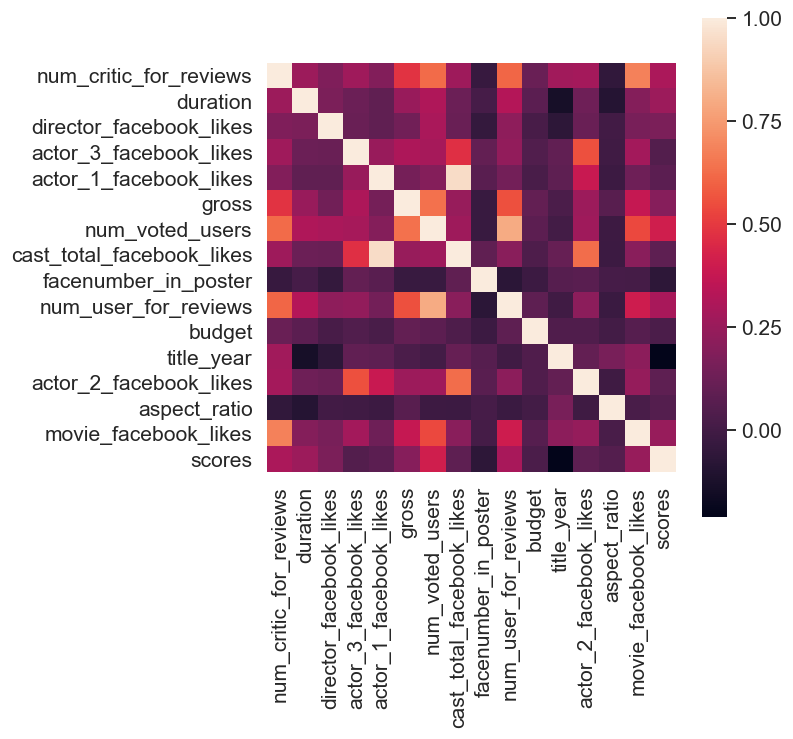

In [326]:
correlation_matrix = dataset.corr()

plt.figure(dpi=110,figsize=(6,6))
sns.heatmap(correlation_matrix, square=True,annot=False)
plt.show()

Lastly, we can plot a pairwise plot of the dependent variable and some of the better predictors in order to see how they are related. We can see from these plots that the relationship is quite non linear in almost all cases. This may suggest that using non linear classifiers will give improved predictive power.

<Figure size 660x440 with 0 Axes>

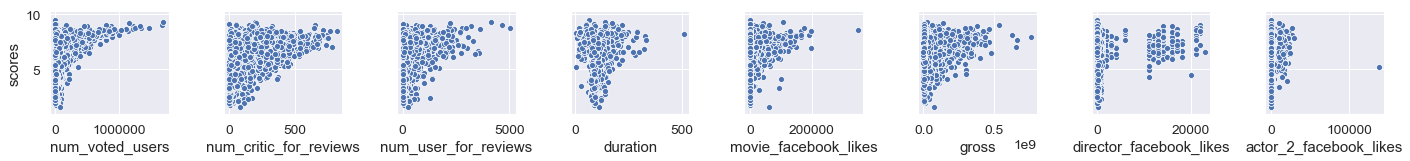

In [327]:
features = ['num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews', 'duration', 'movie_facebook_likes', 'gross', 'director_facebook_likes', 'actor_2_facebook_likes']

plt.figure(dpi=110)
sns.pairplot(data = dataset,y_vars=['scores'], x_vars = features)
plt.show()

### ii) Dealing with Missing Values

First we print the shape of the dataset to understand how many variables we are working with. We print the colums to see what each variable is. We will apply some very basic manipulations to remove useless variables and rearrage the data.

Since the 'score' is the dependent variable, it is useful to move this column to the end of the dataset. We also remove the `imdb_movie_link` columns because it is not useful.

We need to know which columns contain `NaN` (missing) values as these need to be dealt with. We plot a bar chart displaying how many `NaN` values there are per column.

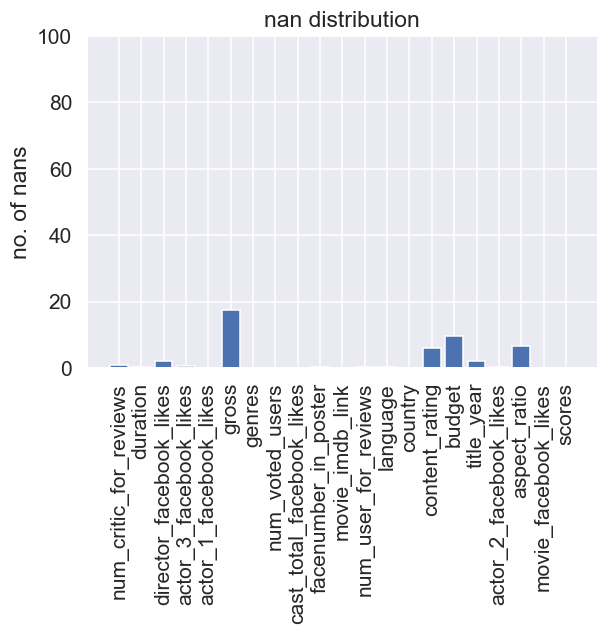

new shape:  (5043, 20)


In [328]:
# count number of NaN values in the columns
nans = []
all_nans = dataset.isna().sum()

for i in range(len(all_nans)):
    nans.append((all_nans[i]/len(dataset))*100)

# plot the number of NaN values per column
plt.figure(dpi=110)
plt.bar(list(dataset.columns), nans)
plt.xticks([i for i in range(len(list(dataset.columns)))], list(dataset.columns), rotation='vertical')
plt.title('nan distribution')
plt.ylim(0,100)
plt.ylabel('no. of nans')
plt.show()

dataset = dataset.drop(columns='movie_imdb_link')
# we remove all rows where there is no score
dataset = dataset.dropna(axis=0,subset=['scores'])
print("new shape: ", dataset.shape)

From this quick analysis we can see that gross has >10% of rows as NaN. We shall just remove this column instead of attempting to impute values. 

We don't have many features in this dataset and we want to avoid deleting datapoints all together, so we can impute the rest of the columns. We will fill the NaNs in continuous columns with the mean and NaNs in the discrete columns with the mode.

In [329]:
print("shape of data before: ", dataset.shape)
# Taking care of missing data
dataset = dataset.drop(columns='gross')

dataset['budget'] = dataset['budget'].fillna(value=dataset['budget'].mean())
dataset['aspect_ratio'] = dataset['aspect_ratio'].fillna(value=dataset['aspect_ratio'].mode()[0])
dataset['director_facebook_likes'] = dataset['director_facebook_likes'].fillna(value=dataset['director_facebook_likes'].mean())
dataset['content_rating'] = dataset['content_rating'].fillna(value=dataset['content_rating'].mode()[0])
dataset['title_year'] = dataset['title_year'].fillna(value=dataset['title_year'].mode()[0])
dataset['num_critic_for_reviews'] = dataset['num_critic_for_reviews'].fillna(value=dataset['num_critic_for_reviews'].mean())
dataset['duration'] = dataset['duration'].fillna(value=dataset['duration'].mean())
dataset['actor_3_facebook_likes'] = dataset['actor_3_facebook_likes'].fillna(value=dataset['actor_3_facebook_likes'].mean())
dataset['actor_1_facebook_likes'] = dataset['actor_1_facebook_likes'].fillna(value=dataset['actor_1_facebook_likes'].mean())
dataset['facenumber_in_poster'] = dataset['facenumber_in_poster'].fillna(value=dataset['facenumber_in_poster'].mode()[0])
dataset['num_user_for_reviews'] = dataset['num_user_for_reviews'].fillna(value=dataset['num_user_for_reviews'].mean())
dataset['language'] = dataset['language'].fillna(value=dataset['language'].mode()[0])
dataset['country'] = dataset['country'].fillna(value=dataset['country'].mode()[0])
dataset['actor_2_facebook_likes'] = dataset['actor_2_facebook_likes'].fillna(value=dataset['actor_2_facebook_likes'].mean())

nans = []
all_nans = dataset.isna().sum()
print(all_nans)

shape of data before:  (5043, 20)
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_1_facebook_likes       0
genres                       0
num_voted_users              0
cast_total_facebook_likes    0
facenumber_in_poster         0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
aspect_ratio                 0
movie_facebook_likes         0
scores                       0
dtype: int64


In this way, we have not removed any datapoints and have only removed one feature: gross.

### ii) Removing highly co-correlated features

Features that are highly co-correlated are redundant and are not useful, so we can remove them. For example, if you have 2 variables that are used to predict some output and the 2 variables are highly correlated, using both of them in the model is not necessary since they are very closely related.

We compute the correlation matrix for all of the variables and we will remove all variables that are correlated with correlation coefficient > 0.7. We can easily visualise the correlation matrix by plotting a heatmap of the correlation coefficients.

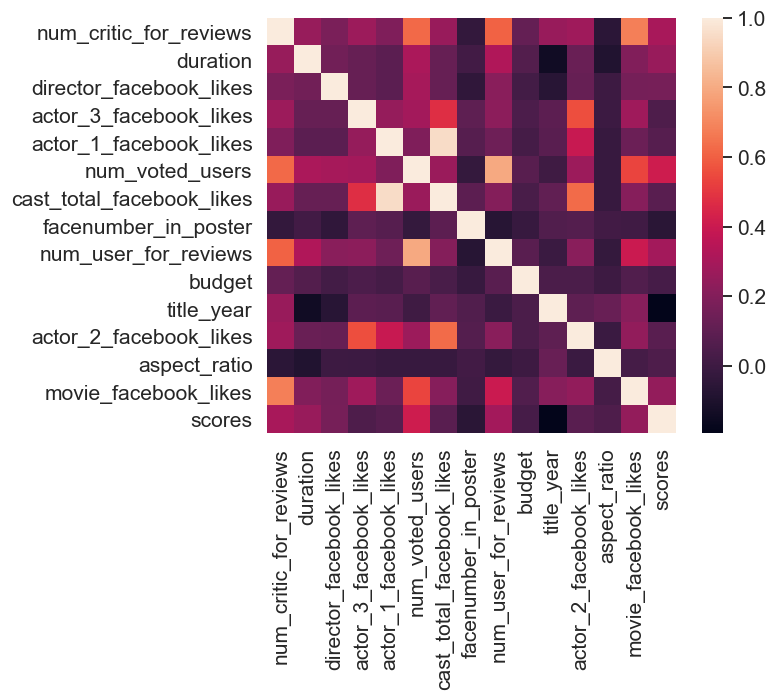

Number of co-correlated features:  2
Co-correlated features:  {'cast_total_facebook_likes', 'num_user_for_reviews'}


In [330]:
from sklearn.feature_selection import VarianceThreshold
import seaborn as sn

correlated_features = set()
correlation_matrix = dataset.corr()

plt.figure(dpi=110,figsize=(6,5))
sn.heatmap(correlation_matrix, annot=False)
plt.show()

# remove correlated features
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print("Number of co-correlated features: ", len(correlated_features))
print("Co-correlated features: ", correlated_features)

dataset.drop(labels=correlated_features, axis=1, inplace=True)

We find from this analysis that `num_user_for_reviews`, which is correlated with `num_voted_users` and `cast_total_facebook_likes`, which is highly correlated with `actor_1_facebook_likes`.

Therefore, we drop the `num_user_for_reviews` and `cast_total_facebook_likes` columns.

## Part 2: Dataset Preprocessing

### i) Categorising the dependent variable

We are not attempting to predict exact scores, we would like to classify movies into categories depending on how good they are. In order for this to work we need to convert the dependent variable (scores) into categories.

We do this by defining ranges for the scores that define how good they are: 1.6 to 4.0 is "terrible", 4.0 to 6.5 is "ok", 6.5 to 7.8 is "good" and above 7.8 is "great".

Text(0, 0.5, 'no. of movies')

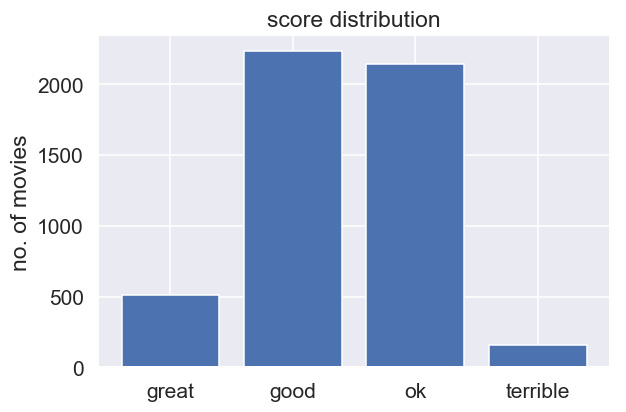

In [331]:
# put the score columns into categories
scores = list(dataset['scores'])
dataset.drop(columns='scores')
score_classes = []

for score in scores:
    if score >= 1.6 and score < 4.0:
        score_classes.append("terrible")
    elif score >= 4.0 and score < 6.5:
        score_classes.append("ok")
    elif score >= 6.5 and score < 7.8:
        score_classes.append("good")
    elif score >=7.8 and score < 10.0:
        score_classes.append("great")
        
dataset['scores'] = score_classes

from collections import Counter
scores = Counter(list(dataset['scores']))

# plot the number of NaN values per column
plt.figure(dpi=110)
plt.bar(scores.keys(), scores.values())
plt.xticks([i for i in range(len(list(scores.keys())))], list(scores.keys()),)
plt.title('score distribution')
plt.ylabel('no. of movies')

The genre feature is likely very important to the movie score. However, the 'genres' column of the dataset contains many genres. For this reason, we will create a new genre column that only contains a single genre, so that it can be onehot encoded properly.

'Action' and 'Adventure' genres appear very frequently, therefore we will suppress their appearance in the new column by removing them if there are other options. We will asign to the new genre column a random genre from the list of possible genres in the row.

In [332]:
import random
random_genre = []

for genres in dataset['genres'].values:
    str_genres = str(genres)
    list_genres = str_genres.split("|")
    
    if 'Action' in list_genres and len(list_genres) > 1:
        list_genres.remove('Action')
    
    if 'Adventure' in list_genres and len(list_genres) > 1:
        list_genres.remove('Adventure')
    
    random_genre.append(random.choice(list_genres))
        
dataset['genres'] = random_genre

We can now print the final features that we will use for model training.

### ii) Split the data into independent and dependent variables

Our output (dependent) variable is the movie class, everything else is an input (independent variable). We will split the input data into these two categories.

Here we also encode the content_rating column so that it can be used for model training. Since content rating is a categorical variable, we need to onehot encode the column.

In [333]:
scores = dataset['scores'].values
X_df = pd.get_dummies(dataset.iloc[:,:-1])

X = X_df.values
y = scores

# Encoding the Dependent Variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_le = le.fit_transform(y)

print(X.shape)
print(y_le)

(5043, 165)
[1 0 0 ... 2 2 0]


### iii) Apply feature scaling

Feature scaling is necessary in our case since there are massive ranges in values in some columns.

In [334]:
# Feature Scaling (necessary for NNs)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

### iv) Split the dataset into training and test set with ratio 90:10

The training set will be used to train our models and the test set will be witheld for validation.

In [335]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size = 0.1, random_state = 0)

## Part 3: Model Training & Evaluation

Now that our data is preprocessed, we can start training models to predict the movie class. We will train several models and evaluate them via K-Fold (K=10) cross validation. At the end we can compare the scores and determine which is the best model.

Since the dependent variable classes are highly imbalanced, we will use F1 score as the evaluation metric instead of accuracy.

### i) Naive Bayes

We will compare several models, the first of which is the Naive Bayes classifier, as it is the simplest model.

Through 10-fold cross validation we achieve an average F1 score of 8.86% ± 1.01, which is very low.

In [336]:
means = []
stds = []

# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, y_train)

y_pred = NB.predict(X_test)

from sklearn.metrics import classification_report, make_scorer
print(classification_report(y_test,y_pred))


# applying k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=NB, X=X_train, y=y_train, cv=10)
# compute the average accuracy and SD across 10 folds
avg = accuracies.mean() * 100
std = accuracies.std() * 100

print("10-fold cross validation: ",avg, "±", std)

means.append(avg)
stds.append(std)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.23      0.37      0.28        52
           2       0.55      0.03      0.05       208
           3       0.03      0.88      0.07        16

   micro avg       0.08      0.08      0.08       505
   macro avg       0.20      0.32      0.10       505
weighted avg       0.25      0.08      0.05       505

10-fold cross validation:  8.727835281252508 ± 0.9446535892764532


### ii) K-Nearest Neighbours

We now attempy a KNN classifier using Euclidean distance and 5 neighbours, achieving an average F1 score of 57.29% ± 1.64, which is a significant improvement on the Naive Bayes.

In [337]:
# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)

from sklearn.metrics import classification_report, make_scorer
print(classification_report(y_test,y_pred))

# applying k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=KNN, X=X_train, y=y_train, cv=10, scoring=make_scorer(f1_score, average='weighted',labels=np.unique(y_pred)))
# compute the average accuracy and SD across 10 folds
avg = accuracies.mean() * 100
std = accuracies.std() * 100

print("10-fold cross validation: ",avg, "±", std)

means.append(avg)
stds.append(std)

              precision    recall  f1-score   support

           0       0.54      0.61      0.57       229
           1       0.58      0.21      0.31        52
           2       0.56      0.61      0.58       208
           3       0.00      0.00      0.00        16

   micro avg       0.55      0.55      0.55       505
   macro avg       0.42      0.36      0.37       505
weighted avg       0.53      0.55      0.53       505



/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


10-fold cross validation:  57.294661037483216 ± 1.643396598628654


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### iii) Support Vector Machine

Using an SVM classifier, we achieve a slight improvement on the KNN classifier, with an average accuracy of 63.60% ± 1.66.

In [308]:
# Training the Kernel SVM model on the Training set
from sklearn.svm import SVC
SVM = SVC(kernel = 'rbf', random_state = 0,gamma='auto')
SVM.fit(X_train, y_train)

y_pred = SVM.predict(X_test)

from sklearn.metrics import classification_report, make_scorer
print(classification_report(y_test,y_pred))

# applying k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=SVM, X=X_train, y=y_train, cv=10, scoring=make_scorer(f1_score, average='weighted',labels=np.unique(y_pred)))
# compute the average accuracy and SD across 10 folds
avg = accuracies.mean() * 100
std = accuracies.std() * 100

print("10-fold cross validation: ",avg, "±", std)

means.append(avg)
stds.append(std)

/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.59      0.63      0.61       229
           1       0.84      0.31      0.45        52
           2       0.60      0.70      0.64       208
           3       0.00      0.00      0.00        16

   micro avg       0.60      0.60      0.60       505
   macro avg       0.51      0.41      0.43       505
weighted avg       0.60      0.60      0.59       505

10-fold cross validation:  63.596179400652744 ± 1.655982444048834


### iv) Random Forest Classifier

We fit a Random Forest Classifier, achieving a slightly better accuracy of 69.43% ± 2.13.

For Random Forest, it is important to identify the optimal number of estimators (trees) to incorporate into the model. We can find the optimal number by fitting using different numbers of trees and then plotting a graph of accuracy vs trees. We can see that the optimal number of trees is around 170.

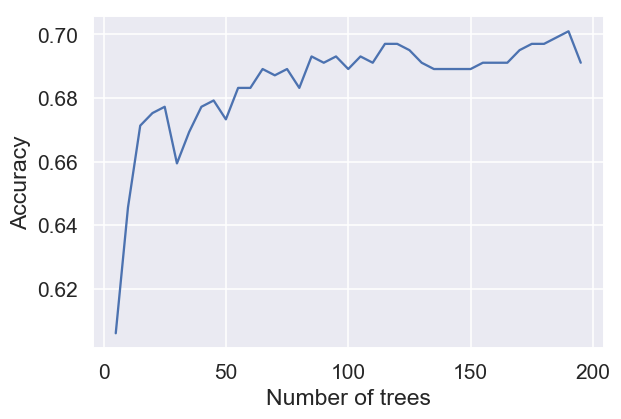

/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.68      0.75      0.71       229
           1       0.89      0.48      0.62        52
           2       0.70      0.76      0.73       208
           3       0.00      0.00      0.00        16

   micro avg       0.70      0.70      0.70       505
   macro avg       0.57      0.50      0.52       505
weighted avg       0.69      0.70      0.69       505

10-fold cross validation:  69.42784148797429 ± 2.134948054857073


In [339]:
# Training the Random Forest Classification model on the Training set
from sklearn.ensemble import RandomForestClassifier
i = 5
accs = []
while(i<200):
    RFC = RandomForestClassifier(n_estimators = i, criterion = 'entropy', random_state = 0)
    RFC.fit(X_train, y_train)

    y_pred = RFC.predict(X_test)

    a = accuracy_score(y_pred,y_test)
    accs.append(a)
    i+=5

plt.figure(dpi=110)
plt.plot([i*5 for i in range(1,40)],accs)
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.show()

import operator
index, _ = max(enumerate(accs), key=operator.itemgetter(1))

RFC = RandomForestClassifier(n_estimators = index*5 + 5, criterion = 'entropy', random_state = 0)
RFC.fit(X_train, y_train)

y_pred = RFC.predict(X_test)

from sklearn.metrics import classification_report, make_scorer
print(classification_report(y_test,y_pred))

# applying k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=RFC, X=X_train, y=y_train, cv=10, scoring=make_scorer(f1_score, average='weighted',labels=np.unique(y_pred)))
# compute the average accuracy and SD across 10 folds
avg = accuracies.mean() * 100
std = accuracies.std() * 100

print("10-fold cross validation: ",avg, "±", std)

means.append(avg)
stds.append(std)

### iv) XGBoost Classifier

Lastly, we train the XGBoost classifier and achieve an average F1 score of 69.15 ± 2.53.

In [310]:
# Training the Kernel SVM model on the Training set
from xgboost import XGBClassifier
XGB = XGBClassifier()
XGB.fit(X_train,y_train)

y_pred = XGB.predict(X_test)

from sklearn.metrics import classification_report, make_scorer
print(classification_report(y_test,y_pred))

# applying k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=XGB, X=X_train, y=y_train, cv=10, scoring=make_scorer(f1_score, average='weighted',labels=np.unique(y_pred)))
# compute the average accuracy and SD across 10 folds
avg = accuracies.mean() * 100
std = accuracies.std() * 100

print("10-fold cross validation: ",avg, "±", std)

means.append(avg)
stds.append(std)

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       229
           1       0.73      0.63      0.68        52
           2       0.66      0.71      0.68       208
           3       0.00      0.00      0.00        16

   micro avg       0.67      0.67      0.67       505
   macro avg       0.52      0.51      0.51       505
weighted avg       0.65      0.67      0.66       505

10-fold cross validation:  69.14542782115306 ± 2.530387701949476


### v) Neural Network

In order to use a neural network the dependent variable must be onehotencoded.

We then define the neural network, which has 3 hidden layers and train with a batch size of 16 for 100 epochs.

The neural network achieves an average F1 score of

In [311]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

for train, test in kfold.split(X_train, y_train):
    y_ohe = pd.get_dummies(pd.DataFrame(y_train)).values
    # initialise the ANN
    Net = Sequential()
    # Add input layer + first hidden layer
    Net.add(Dense(units = 8, activation = 'relu'))
    # Add second & third hidden layers
    Net.add(Dense(units = 12, activation = 'relu'))
    # Add the output layer
    Net.add(Dense(units = 4, activation = 'sigmoid'))
    # Compile the Neural Network
    Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    Net.fit(X_train[train], y_ohe[train], batch_size = 32, epochs = 100, verbose=0)
    # evaluate the model
    scores = Net.evaluate(X_train[test], y_ohe[test], verbose=0)
    print("%s: %.2f%%" % (Net.metrics_names[1], scores[1]*100))
print("%.2f%% ± %.2f%%" % (np.mean(cvscores), np.std(cvscores)))

means.append(np.mean(cvscores))
stds.append(np.std(cvscores))

accuracy: 44.18%
accuracy: 63.08%
accuracy: 68.57%
accuracy: 44.18%
accuracy: 44.18%
accuracy: 63.66%
accuracy: 62.69%
accuracy: 60.18%
accuracy: 65.49%
accuracy: 44.25%
nan% ± nan%


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Ricardo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Ricardo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/Ricardo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/Ricardo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### vi) Model Comparison

We will summarise the 10-fold cross validation statistics we have gathered for each model we built by plotting a bar chart of the values.

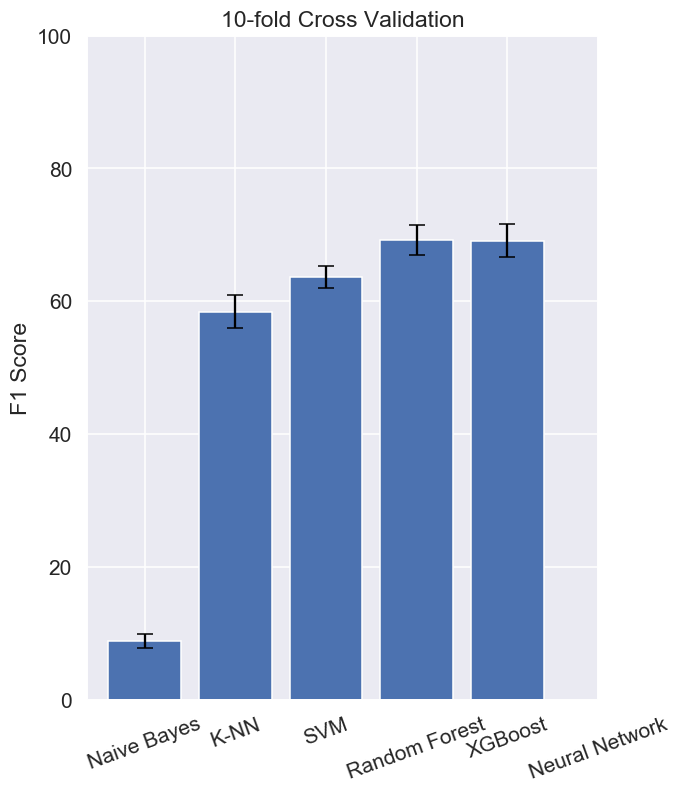

In [313]:
models = ['Naive Bayes', 'K-NN', 'SVM', 'Random Forest', 'XGBoost', 'Neural Network']

# plot the number of NaN values per column
plt.figure(dpi=110,figsize=(6,8))
plt.bar(models, means, yerr=stds,align='center',ecolor='black', capsize=5)
plt.xticks([i for i in range(len(models))], models, rotation=20)
plt.title('10-fold Cross Validation')
plt.ylim(0,100)
plt.ylabel('F1 Score')
plt.show()

## Part 4: Summary and Conclusions

### i) Key Takeaways

In this analysis we have successfully built several models that predict how good a movie will be based on several inputs. We compared 5 classification models: Naïve Bayes, K Nearest Neighbours, Support Vector Machine, Random Forest Classifier and an Artificial Neural Network Classifier and found that the Random Forest Classifier with 25 trees performs the best with an average accuracy of 67.4%. 

An important conclusion that we can draw from this analysis is that sometimes the simpler model (Random Forest) is better than the complex model (Neural Net). A complex and sophisticated model will produce exceptional performance for specific tasks, making them desirable. However, this does not mean they are a magic tool that will achieve excellent performance in all use cases. Sometimes, as we have observed, simpler is better.

Some would likely argue that this accuracy is impressive; it is certainly not trivial. However, if we were building some kind of production prediction system to be used in the real world, 67.4% is simply not enough. We would really like to see accuracies of >85%. It is important to note that this analysis certainly does not show that achieving accuracies of >85% on this dataset are impossible.

### ii) Limitations and Future Work

A major limitation of the work here is that we have not used all of the columns available to us. We have dropped many columns because they are not related to the dependent variable (for example the name of the movie does not affect how good it is, it is simply a unique identifier). Other columns were dropped because they are extremely sparse. For example, we may think that the director name is a good indicator of how good a movie will be. This is certainly true for us humans, but only because we have additional information about these directors - we know that Martin Scorcesse is a good director, so his movie is probably good. But to the model, there are very few observations of when Martin Scorcesse has made a film in a sea of thousands of other directors. In short, this column is extremely noisy - there are so many directors and it is almost impossible to filter out the good and bad. This extends naturally to the actor name columns.

However, one column that does not fall into either of these categories is the genre column. Since there are few genres, many films fall into categories and we can use this to make predictions. Naturally, we know that a film's genre is related to its score - dramas and thrillers generally have higher scores than family comedies, for example, since they tend to deal with more profound and grandiose themes. Therefore, the next step for this analysis would be to add the genre column as an additional input. This is tricky for several reasons. The genre information is stored in string format, which requires parsing into a single genre column. This column would then need to be one-hot encoded. This will be completed in a future analysis.

In terms of improving the models that we have already, one thing we could do is hyperparameter optimisation of the neural network model. Since the accuracy score is very close to being the best, perhaps optimising the hyperparameters via a grid search would improve the model enough to take the top spot.

At the very least, the work here is a good starting point. An accuracy of around 70% is not trivial, but there is still room for improvement.